# FOREST COVER TYPE - Analyse des données

On s'intéresse ici à prédire la type de couverture végétale de parcelles de $30\text{m}^2$ situées dans le parc national Roosevelt, au Colorado. Pour cela, nous avons des données labélisées d'autres parcelles de même dimension.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
print('Python: {}'.format(sys.version))  # Python version
print('numpy: {}'.format(np.__version__))  # Numpy version
print('pandas: {}'.format(pd.__version__))  # Pandas version
print('matplotlib: {}'.format(matplotlib.__version__))# Matplotlib version
print('seaborn: {}'.format(sns.__version__))  # seaborn version
print('sklearn: {}'.format(sklearn.__version__))  # sklearn version

Python: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
numpy: 1.23.5
pandas: 1.5.3
matplotlib: 3.7.0
seaborn: 0.12.2
sklearn: 1.2.1


----
----

## I. Les données

Les données d'entraînement et de test sont stockées dans le dossier `./data/` dans les fichiers `train.csv` et `test.csv`. Ces données sont ensuite chargées dans les DataFrames `train_df` et `test_df`.

In [3]:
import os

_REP_PATH_ = os.getcwd()

In [4]:
# Initialisation des DataFrames contenant les données

# DataFrame des données d'entrainement
train_df = pd.read_csv(_REP_PATH_+'/data/train.csv', index_col = 0)

# DataFrame des données de test
test_df = pd.read_csv(_REP_PATH_+'/data/test.csv', index_col = 0)

# Affichage des premiers individus des DataFrames
train_df.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2909      28     18                               182   
1       2757     334     30                               212   
2       3283     248      4                               150   
3       3019     330     14                               541   
4       3039     340     20                               474   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              58                             1350   
1                              83                             1384   
2                              15                             5601   
3                            -101                             1811   
4                              74                             3407   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            210             197            117   
1            137             184            177   
2            211             243            170   
3            186             222            175   
4            175             207            169   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                2160  ...            0            0   
1                                1570  ...            0            0   
2                                 892  ...            0            0   
3                                2154  ...            0            0   
4                                1879  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            1   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           2  
1            0            0           2  
2            0            0           1  
3            0            0           2  
4            1            0           1  

[5 rows x 55 columns]

Les données ont été correctement extraite et nous observons que les variables décrivant le type de sol `Soil_TypeXX` ont un encodage one-hot. Cet encodage permet de convertir des données catégorielles en données numériques, tout en préservant leur caractère distinctif. Cependant, cela se fait au détriment de la dimensionnalité des données. Observons donc la taille des données qui nous ont été confiées.

In [5]:
# dimension des données de test et d'entrainement
# où x sera le nombre d'individu
# et y le nombre de features
x, y = train_df.shape
print(f"Les données d'entraînement ont {x} individus et {y-1} variables pour prédire la couverture végétale.\n")

x, y = test_df.shape
print(f"Les données de test ont {x} individus et {y} variables pour prédire la couverture végétale.\n")

# Observons le type de chaque variable
print("Type pour les données d'entraînement: \n",train_df.dtypes)

print("\n Type pour les données de test : \n", test_df.dtypes)

Les données d'entraînement ont 100000 individus et 54 variables pour prédire la couverture végétale.

Les données de test ont 481012 individus et 54 variables pour prédire la couverture végétale.

Type pour les données d'entraînement: 
 Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4     

Les données de test et d'entraînement sont bien conformes entre elles. Nous observons aussi qu'il y a environ 5 fois plus de données de test que d'entraînement.

Ces données peuvent aussi être sujettes à des valeurs manquantes. Nous allons donc observer le nombre de valeurs manquantes dans le DataFrame d'entraînement `train_df`.

In [6]:
# Nombre de données manquantes
train_df.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


Le dataset d'entrainement est donc complet, nous pouvons donc poursuivre notre analyse sans modification dans le DataFrame d'entrainement. Mais avant cela, expliquons un peu les données.

### Explication des données

Notre jeu de données comporte 54 variables et une variable cible `Cover_Type`. Parmi ces 54 variables, 10 sont des variables quantitatives et 44 des variables binaires. Ces variables binaires proviennent (pour 40 d'entre elles) de l'encodage one-hot des deux premiers chiffres du code ELU, qui décrivent une combinaison entre une zone climatique et une zone géologique. En effet, la fiche d'information des données (stockée à l'adresse `./data/covtype.info`) nous donne les informations suivantes.

| Feature Name | ELU Code | Description |
| ------------ | ----- |----- |
| Soil_Type1    |   2702	|	Cathedral family - Rock outcrop complex, extremely stony.|
| Soil_Type2	|   2703	|	Vanet - Ratake families complex, very stony.|
| Soil_Type3	|   2704	|	Haploborolis - Rock outcrop complex, rubbly.|
| Soil_Type4	|   2705	|	Ratake family - Rock outcrop complex, rubbly.|
| Soil_Type5	|   2706	|	Vanet family - Rock outcrop complex complex, rubbly.|
| Soil_Type6	|   2717	|	Vanet - Wetmore families - Rock outcrop complex, stony.|
| Soil_Type7	|   3501    |	Gothic family.|
| Soil_Type8	|   3502	|	Supervisor - Limber families complex.|
| Soil_Type9	|   4201    |	Troutville family, very stony.|
| Soil_Type10	|   4703	|	Bullwark - Catamount families - Rock outcrop complex, rubbly.|
| Soil_Type11	|   4704	|	Bullwark - Catamount families - Rock land complex, rubbly.|
| Soil_Type12	|   4744    |	Legault family - Rock land complex, stony.|
| Soil_Type13	|   4758	|	Catamount family - Rock land - Bullwark family complex, rubbly.|
| Soil_Type14	|   5101	|	Pachic Argiborolis - Aquolis complex.|
| Soil_Type15	|   5151	|	unspecified in the USFS Soil and ELU Survey.|
| Soil_Type16	|   6101	|	Cryaquolis - Cryoborolis complex.|
| Soil_Type17	|   6102	|	Gateview family - Cryaquolis complex.|
| Soil_Type18	|   6731	|	Rogert family, very stony.|
| Soil_Type19	|   7101	|	Typic Cryaquolis - Borohemists complex.|
| Soil_Type20	|   7102	|	Typic Cryaquepts - Typic Cryaquolls complex.|
| Soil_Type21	|   7103	|	Typic Cryaquolls - Leighcan family, till substratum complex.|
| Soil_Type22	|   7201	|	Leighcan family, till substratum, extremely bouldery.|
| Soil_Type23	|   7202	|	Leighcan family, till substratum - Typic Cryaquolls complex.|
| Soil_Type24	|   7700	|	Leighcan family, extremely stony.|
| Soil_Type25	|   7701	|	Leighcan family, warm, extremely stony.|
| Soil_Type26	|   7702	|	Granile - Catamount families complex, very stony.|
| Soil_Type27	|   7709	|	Leighcan family, warm - Rock outcrop complex, extremely stony.|
| Soil_Type28	|   7710	|	Leighcan family - Rock outcrop complex, extremely stony.|
| Soil_Type29	|   7745	|	Como - Legault families complex, extremely stony.|
| Soil_Type30	|   7746	|	Como family - Rock land - Legault family complex, extremely stony.|
| Soil_Type31	|   7755	|	Leighcan - Catamount families complex, extremely stony.|
| Soil_Type32	|   7756	|	Catamount family - Rock outcrop - Leighcan family complex, extremely stony.|
| Soil_Type33	|   7757	|	Leighcan - Catamount families - Rock outcrop complex, extremely stony.|
| Soil_Type34	|   7790	|	Cryorthents - Rock land complex, extremely stony.|
| Soil_Type35	|   8703	|	Cryumbrepts - Rock outcrop - Cryaquepts complex.|
| Soil_Type36	|   8707	|	Bross family - Rock land - Cryumbrepts complex, extremely stony.|
| Soil_Type37	|   8708	|	Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.|
| Soil_Type38	|   8771	|	Leighcan - Moran families - Cryaquolls complex, extremely stony.|
| Soil_Type39	|   8772	|	Moran family - Cryorthents - Leighcan family complex, extremely stony.|
| Soil_Type40	|   8776	|	Moran family - Cryorthents - Rock land complex, extremely stony.|

Avec les correspondances des deux premiers chiffres du code ELU données par :

``` c
First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic
```

Nous pouvons observer que, pour une même zone climatique et géologique, il peut y avoir différents `Soil_TypeXX`. Inclure deux nouvelles variables `Climatic_Zone` et `Geologic_Zone` pourrait aider nos modèles dans le regroupement des données par classe.

In [7]:
### encodage du code ELU dans nos dataframes

def encoding_ELU(dataFrame : pd.DataFrame):
    """
    On trouve le numéro ELU en fonction du Soil_Type et on l'encode dans le dataframe

    Args:
        dataFrame (pd.DataFrame): DataFrame contenant seulement les Soil_Type
    """
    
    soil_type = [f"Soil_Type{i}" for i in range(1,41)]
    
    climatic_zone = []
    geologic_zone = []
    
    # dictionnaire qui associe à chaque Soil_Type les deux premiers chiffres du code ELU correspondant
    number_ELU = {
        'Soil_Type1':"27",
        'Soil_Type2':"27",
        'Soil_Type3':"27",
        'Soil_Type4':"27",
        'Soil_Type5':"27",
        'Soil_Type6':"27",
        'Soil_Type7':"35",
        'Soil_Type8':"35",
        'Soil_Type9':"42",
        'Soil_Type10':"47",
        'Soil_Type11':"47",
        'Soil_Type12':"47",
        'Soil_Type13':"47",
        'Soil_Type14':"51",
        'Soil_Type15':"51",
        'Soil_Type16':"61",
        'Soil_Type17':"61",
        'Soil_Type18':"67",
        'Soil_Type19':"71",
        'Soil_Type20':"71",
        'Soil_Type21':"71",
        'Soil_Type22':"72",
        'Soil_Type23':"72",
        'Soil_Type24':"77",
        'Soil_Type25':"77",
        'Soil_Type26':"77",
        'Soil_Type27':"77",
        'Soil_Type28':"77",
        'Soil_Type29':"77",
        'Soil_Type30':"77",
        'Soil_Type31':"77",
        'Soil_Type32':"77",
        'Soil_Type33':"77",
        'Soil_Type34':"77",
        'Soil_Type35':"87",
        'Soil_Type36':"87",
        'Soil_Type37':"87",
        'Soil_Type38':"87",
        'Soil_Type39':"87",
        'Soil_Type40':"87"
    }
    
    # On regarde le dataframe sur les Soil_Type
    df = dataFrame[soil_type]
    
    for index, individu in df.iterrows():
        # On reagrde individu par individu pour retrouver le code ELU associé à la parcelle
        
        # On prend l'indice de colonne associé au Soil_Type
        ind_soil_type = list(df.columns[df.iloc[index] == 1])
        
        # On prend la valeur du numéro ELU associé à la clé Soil_type correspondante
        elu = number_ELU[ind_soil_type[0]]
        
        # On ajout aux list climatic_zone et geologic_zone la bon numéro du code ELU
        climatic_zone.append(int(elu[0]))
        geologic_zone.append(int(elu[1]))
    
    # On encode les tableaux précedent en one-hot
    climatic_one_hot = pd.get_dummies(climatic_zone, prefix = 'Climatic_Zone')
    geologic_one_hot = pd.get_dummies(geologic_zone, prefix = 'Geologic_Zone')
    
    # liste de 1 à 8 pour connaitre les zones climatiques et géologiques non citées
    ind = [i for i in range(1,9)]
    
    # On retrouve les zones non citées
    no_climat = list(set(ind).difference(list(set(climatic_zone))))
    no_geo = list(set(ind).difference(list(set(geologic_zone))))
    
    # on fixe à 0 les zones non citées 
    if len(no_climat) !=0:
        for i in no_climat:
            dataFrame[f"Climatic_Zone_{i}"] = 0
    
    if len(no_geo) != 0:
        for i in no_geo:
            dataFrame[f"Geologic_Zone_{i}"] = 0
        
    return pd.concat([dataFrame, climatic_one_hot, geologic_one_hot], axis=1)

In [8]:
### encodage du code ELU pour le data set d'entrainement

soil_type = [f"Soil_Type{i}" for i in range(1,41)]

train_df = encoding_ELU(train_df)

train_df.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2909      28     18                               182   
1       2757     334     30                               212   
2       3283     248      4                               150   
3       3019     330     14                               541   
4       3039     340     20                               474   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              58                             1350   
1                              83                             1384   
2                              15                             5601   
3                            -101                             1811   
4                              74                             3407   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            210             197            117   
1            137             184            177   
2            211             243            170   
3            186             222            175   
4            175             207            169   

   Horizontal_Distance_To_Fire_Points  ...  Climatic_Zone_3  Climatic_Zone_4  \
0                                2160  ...                0                0   
1                                1570  ...                0                0   
2                                 892  ...                0                0   
3                                2154  ...                0                0   
4                                1879  ...                0                0   

   Climatic_Zone_5  Climatic_Zone_6  Climatic_Zone_7  Climatic_Zone_8  \
0                0                0                1                0   
1                0                0                1                0   
2                0                0                0                1   
3                0                0                1                0   
4                0                0                0                1   

   Geologic_Zone_1  Geologic_Zone_2  Geologic_Zone_5  Geologic_Zone_7  
0                0                0                0                1  
1                0                0                0                1  
2                0                0                0                1  
3                0                0                0                1  
4                0                0                0                1  

[5 rows x 71 columns]

Il sera donc intéressant de regarder la répartition des `Cover_Type` en fonction du couple `Climatic_Zone`, `Geologic_Zone`.

`Cover_Type` est une variable catégorielle de 1 à 7 qui représente le type de végétation présente dans la parcelle étudiée. 

| Numéro | Catégorie |
| --- | ---- |
| 1 | Spruce / Fir |
| 2 | Lodgepole Pine |
| 3 | Ponderosa Pine |
| 4 | Cottonwood / Willow |
| 5 | Aspen |
| 6 | Douglas-fir |
| 7 | Krummholz |

----

### I.1) Analyse statistique des variables

Comme dit précédemment, les données comportent à la fois des variables quantitatives et catégorielles. Nous allons donc les analyser séparément.

In [9]:
### Définition des variables contenant des données binaires

binary_columns =  [f"Wilderness_Area{i}" for i in range(1,5)] \
                + soil_type \
                + [f"Climatic_Zone_{i}" for i in range(1,9)] \
                + [f"Geologic_Zone_{i}" for i in range(1,9)]

#### **Statistiques des variables quantitatives**

In [10]:
## On prend seulement en compte les variables quantitatives

num_fea = train_df.drop(columns= binary_columns + ["Cover_Type"])

num_fea.describe()

Elevation         Aspect          Slope  \
count  100000.000000  100000.000000  100000.000000   
mean     2959.215150     155.551260      14.122850   
std       280.832825     111.759698       7.507368   
min      1860.000000       0.000000       0.000000   
25%      2809.000000      59.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      62.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     100000.000000                   100000.000000   
mean                         269.605630                       46.821590   
std                          212.770595                       58.689319   
min                            0.000000                     -161.000000   
25%                          108.000000                        7.000000   
50%                          218.000000                       30.000000   
75%                          384.000000                       69.000000   
max                         1383.000000                      598.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    100000.000000  100000.000000   100000.000000   
mean                       2350.361130     212.103800      223.348670   
std                        1560.499103      26.841126       19.756411   
min                           0.000000       0.000000       42.000000   
25%                        1103.000000     198.000000      213.000000   
50%                        1992.000000     218.000000      226.000000   
75%                        3331.250000     231.000000      237.000000   
max                        7078.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  
count  100000.000000                       100000.000000  
mean      142.585660                         1976.436530  
std        38.459542                         1324.925172  
min         0.000000                            0.000000  
25%       119.000000                         1020.000000  
50%       143.000000                         1704.000000  
75%       169.000000                         2549.000000  
max       254.000000                         7126.000000

Nous avons stocké dans le DataFrame `num_fea` l'ensemble des variables quantitatives, en excluant la variable objectif `Cover_Type`, et nous obeservons des caractéristiques intéressantes :
- La moyenne des features varie d'environ 6 à 2600. De plus, les différentes features sont données dans des unités différentes, en mètres pour `Elevation`, en degrés pour `Slope`, etc. La normalisation des données sera donc envisageable.

- Toutes les variables ont une valeur minimale de 0, sauf les variables `Elevation` et `Vertical_Distance_To_Hydrology`. `Elevation` a la valeur minimale la plus élevée et `Vertical_Distance_To_Hydrology` la plus basse, étant négative.
- Les variables `Hillshade` ont une valeur maximale similaire de 254, tandis que `Horizontal_Distance_To_Fire_Points` a la valeur la plus élevée, suivie de la variable `Horizontal_Distance_To_Roadways`, et ces deux variables ont également les intervalles les plus larges de toutes les variables. `Slope` a la valeur maximale la plus basse ainsi que l'intervalle le plus faible, suivi de la variable `Aspect`.

Si certaines variables sont si largement réparties et ont des valeurs élevées, alors que d'autres ne le sont pas, c'est parce que 5 des 10 variables sont mesurées en mètres, incluant (`Elevation`, `Horizontal_Distance_To_Hydrology`, `Vertical_Distance_To_Hydrology`, `Horizontal_Distance_To_Roadways`, `Horizontal_Distance_To_Fire_Points`). Il est donc logique que celles-ci aient des valeurs et des intervalles élevés. Les variables comme `Aspect` et `Slope` sont mesurées en degrés, leur valeur maximale ne peut donc pas dépasser 360. Quant aux `Hillshade`, elles peuvent atteindre une valeur maximale de 255.

#### **Statistiques des variables binaires**

In [11]:
## On prend seulement en compte les variables binaires

bin_fea = train_df[binary_columns]

train_df[binary_columns  \
        + [f"Climatic_Zone_{i}" for i in range(1,9)] \
        + [f"Geologic_Zone_{i}" for i in range(1,9)]].describe()

Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4  \
count     100000.000000     100000.000000     100000.000000     100000.000000   
mean           0.448040          0.051140          0.436230          0.064590   
std            0.497295          0.220284          0.495919          0.245802   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            1.000000          0.000000          1.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

          Soil_Type1     Soil_Type2     Soil_Type3     Soil_Type4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.005220       0.013070       0.008570       0.021020   
std         0.072061       0.113575       0.092177       0.143452   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Soil_Type5    Soil_Type6  ...  Climatic_Zone_7  Climatic_Zone_8  \
count  100000.000000  100000.00000  ...    100000.000000     100000.00000   
mean        0.002720       0.01104  ...         0.688770          0.07123   
std         0.052083       0.10449  ...         0.462999          0.25721   
min         0.000000       0.00000  ...         0.000000          0.00000   
25%         0.000000       0.00000  ...         0.000000          0.00000   
50%         0.000000       0.00000  ...         1.000000          0.00000   
75%         0.000000       0.00000  ...         1.000000          0.00000   
max         1.000000       1.00000  ...         1.000000          1.00000   

       Geologic_Zone_1  Geologic_Zone_2  Geologic_Zone_3  Geologic_Zone_4  \
count    100000.000000    100000.000000         100000.0         100000.0   
mean          0.035940         0.157810              0.0              0.0   
std           0.186142         0.364565              0.0              0.0   
min           0.000000         0.000000              0.0              0.0   
25%           0.000000         0.000000              0.0              0.0   
50%           0.000000         0.000000              0.0              0.0   
75%           0.000000         0.000000              0.0              0.0   
max           1.000000         1.000000              0.0              0.0   

       Geologic_Zone_5  Geologic_Zone_6  Geologic_Zone_7  Geologic_Zone_8  
count    100000.000000         100000.0     100000.00000         100000.0  
mean          0.000520              0.0          0.80573              0.0  
std           0.022798              0.0          0.39564              0.0  
min           0.000000              0.0          0.00000              0.0  
25%           0.000000              0.0          1.00000              0.0  
50%           0.000000              0.0          1.00000              0.0  
75%           0.000000              0.0          1.00000              0.0  
max           1.000000              0.0          1.00000              0.0  

[8 rows x 76 columns]

Nous avons stocké dans le DataFrame `bin_fea` l'ensemble des variables quantitatives, en excluant la variable cible `Cover_Type`. Étant donné qu'ici les valeurs peuvent être seulement des 0 ou des 1, les statistiques nous donnent d'importantes informations.

- `Wilderness_Area1` présente la moyenne la plus élevée, suivie par `Wilderness_Area3`, ce qui signifie que `Wilderness_Area1` est le plus présent dans les données par rapport aux autres zones sauvages. En d'autres termes, la plupart des observations ont pour variables soit `Wilderness_Area1`, soit `Wilderness_Area3`. `Wilderness_Area2` apparaît le moins fréquemment. Nous visualiserons ceci ainsi que les variables `Soil_Type` plus tard pour mieux comprendre ces données.

- Une autre chose à noter ici est que si nous additionnons toutes les moyennes des zones sauvages `Wilderness_Area` 0,448864 + 0,051434 + 0,436074 + 0,063627, nous obtenons le résultat 0,999999, soit approximativement 1. Cela a du sens car toutes les observations peuvent provenir d’une seule zone sauvage.

- Ainsi, si nous analysons cela sous l’angle des probabilités, nous pouvons dire que la prochaine observation a 44,8% de probabilité d’être issue de `Wilderness_Area1`, 43,6% de probabilité d’être issue de `Wilderness_Area3` et ainsi de suite pour les autres.

- Nous pouvons documenter de la même manière les types de sols `Soil_Type`.

- Par construction, de nombreuses `Climatic_Zone` et `Geological_Zone` ont des valeurs égales à 0. Parmi les classes non nulles, `Climatic_Zone_7` est celle qui a la plus grande moyenne, avec 68 % des effectifs, et `Climatic_Zone_4` a la deuxième moyenne la plus élevée, avec 16 %. Seule `Climatic_Zone_1` est fixée à zéro dans notre jeu de données, c'est-à-dire qu'il n'y a pas de zone catégorisée comme sèche et de basse altitude, tandis que la moitié des zones étudiées ont un climat subalpin. À contrario, de nombreuses `Geological_Zone` sont fixées à 0 (`Geological_Zone_3`, `Geological_Zone_4`, `Geological_Zone_6` et `Geological_Zone_8`) avec un effectif de 80% pour la seule `Geological_Zone_7`.

En regardant ces statistiques de deux types de données différents, et puisque les variables présentent des étendues différentes et une répartition inégale, nous allons mettre ces données à l’échelle afin que toutes les variables aient des intervalles similaires entre 0 et 1. Certains algorithmes sont très sensibles aux valeurs élevées, ce qui peut produire des résultats inappropriés, tandis que d’autres ne le sont pas. Par mesure de précaution, nous allons les mettre à l’échelle.

#### **Skewness des données**

In [12]:
### Skew

num_fea.skew().sort_values(ascending=False)

Vertical_Distance_To_Hydrology        1.815016
Horizontal_Distance_To_Fire_Points    1.287213
Horizontal_Distance_To_Hydrology      1.143983
Slope                                 0.783078
Horizontal_Distance_To_Roadways       0.712500
Aspect                                0.402186
Hillshade_3pm                        -0.276266
Elevation                            -0.812441
Hillshade_Noon                       -1.049436
Hillshade_9am                        -1.174634
dtype: float64

In [13]:
bin_fea.skew().sort_values(ascending=False)

Soil_Type7          79.039152
Soil_Type36         70.690524
Soil_Type8          52.676953
Geologic_Zone_5     43.819346
Climatic_Zone_3     43.819346
Soil_Type37         41.850198
Soil_Type25         35.996402
Climatic_Zone_5     30.240035
Soil_Type14         30.240035
Soil_Type28         27.366101
Soil_Type21         25.762144
Soil_Type27         22.937267
Soil_Type9          22.018662
Soil_Type5          19.096092
Soil_Type34         18.819041
Soil_Type35         17.935665
Soil_Type18         17.401803
Soil_Type26         15.878084
Soil_Type16         14.314719
Soil_Type1          13.732508
Soil_Type17         12.937105
Soil_Type19         12.075623
Soil_Type3          10.662934
Soil_Type6           9.359140
Soil_Type2           8.574762
Climatic_Zone_6      8.288594
Soil_Type40          7.860304
Soil_Type20          7.727479
Soil_Type4           6.678065
Soil_Type11          6.565548
Soil_Type39          6.213360
Soil_Type38          5.734529
Soil_Type13          5.435290
Geologic_Z

-Nous observons que `Soil_Type7` a la plus forte skewness positive, ce qui signifie que la masse de la distribution est concentrée à gauche et possède une longue queue à droite. `Soil_Type7` est suivi par `Soil_Type36`, `Soil_Type8`, `Geologic_Zone_5` et `Climatic_Zone_3`. Dans ce cas, le mode de la variable est le plus à gauche, suivi de la médiane et de la moyenne. Cela signifie que la plupart des observations auront une valeur de 0 pour cette caractéristique.

-En général, en regardant les scores d'asymétrie des `Soil_Type`, il semble que nous pourrions réduire nos dimensions en supprimant certains types de sol, mais seulement s'ils n'apportent pas d'informations distinctes pour améliorer la performance de nos modèles. Nous verrons comment évaluer cela dans les sections suivantes.

-Les distributions de `Elevation` et `Hillshade` présentent une asymétrie négative, l'inverse de l'asymétrie positive, où le mode est le plus à droite, suivi de la médiane et de la moyenne.

Comme évoqué précédemment, les algorithmes de machine learning peuvent être très sensibles à de telles plages de valeurs, ce qui peut produire des résultats inappropriés ou faibles.

#### **Distribution des différentes classes**

In [14]:
### On regarde le nombre de données par Cover_Type

train_df.groupby('Cover_Type').size()

Cover_Type
1    36410
2    48676
3     6273
4      471
5     1635
6     2967
7     3568
dtype: int64

On observe une répartition disparate des individus dans les classes. En effet, les deux premières classes (`Spruce / Fir` et `Lodgepole Pine`) regroupent à elles seules 86 % des données d'entraînement.

Une solution à ce déséquilibre de classes serait de faire un bootstrap des données. Nous verrons que, dans notre cas, les données disponibles sont suffisantes pour atteindre un très bon score.

### I.2) Visualisation des variables

Dans cette partie, nous allons nous intéresser aux statistiques et distributions des différentes variables, quantitatives et binaire, afin de pouvoir extraire les premières intuitions de modélisation du jeu de données. 

#### **Visualisation des variables quantitatives**

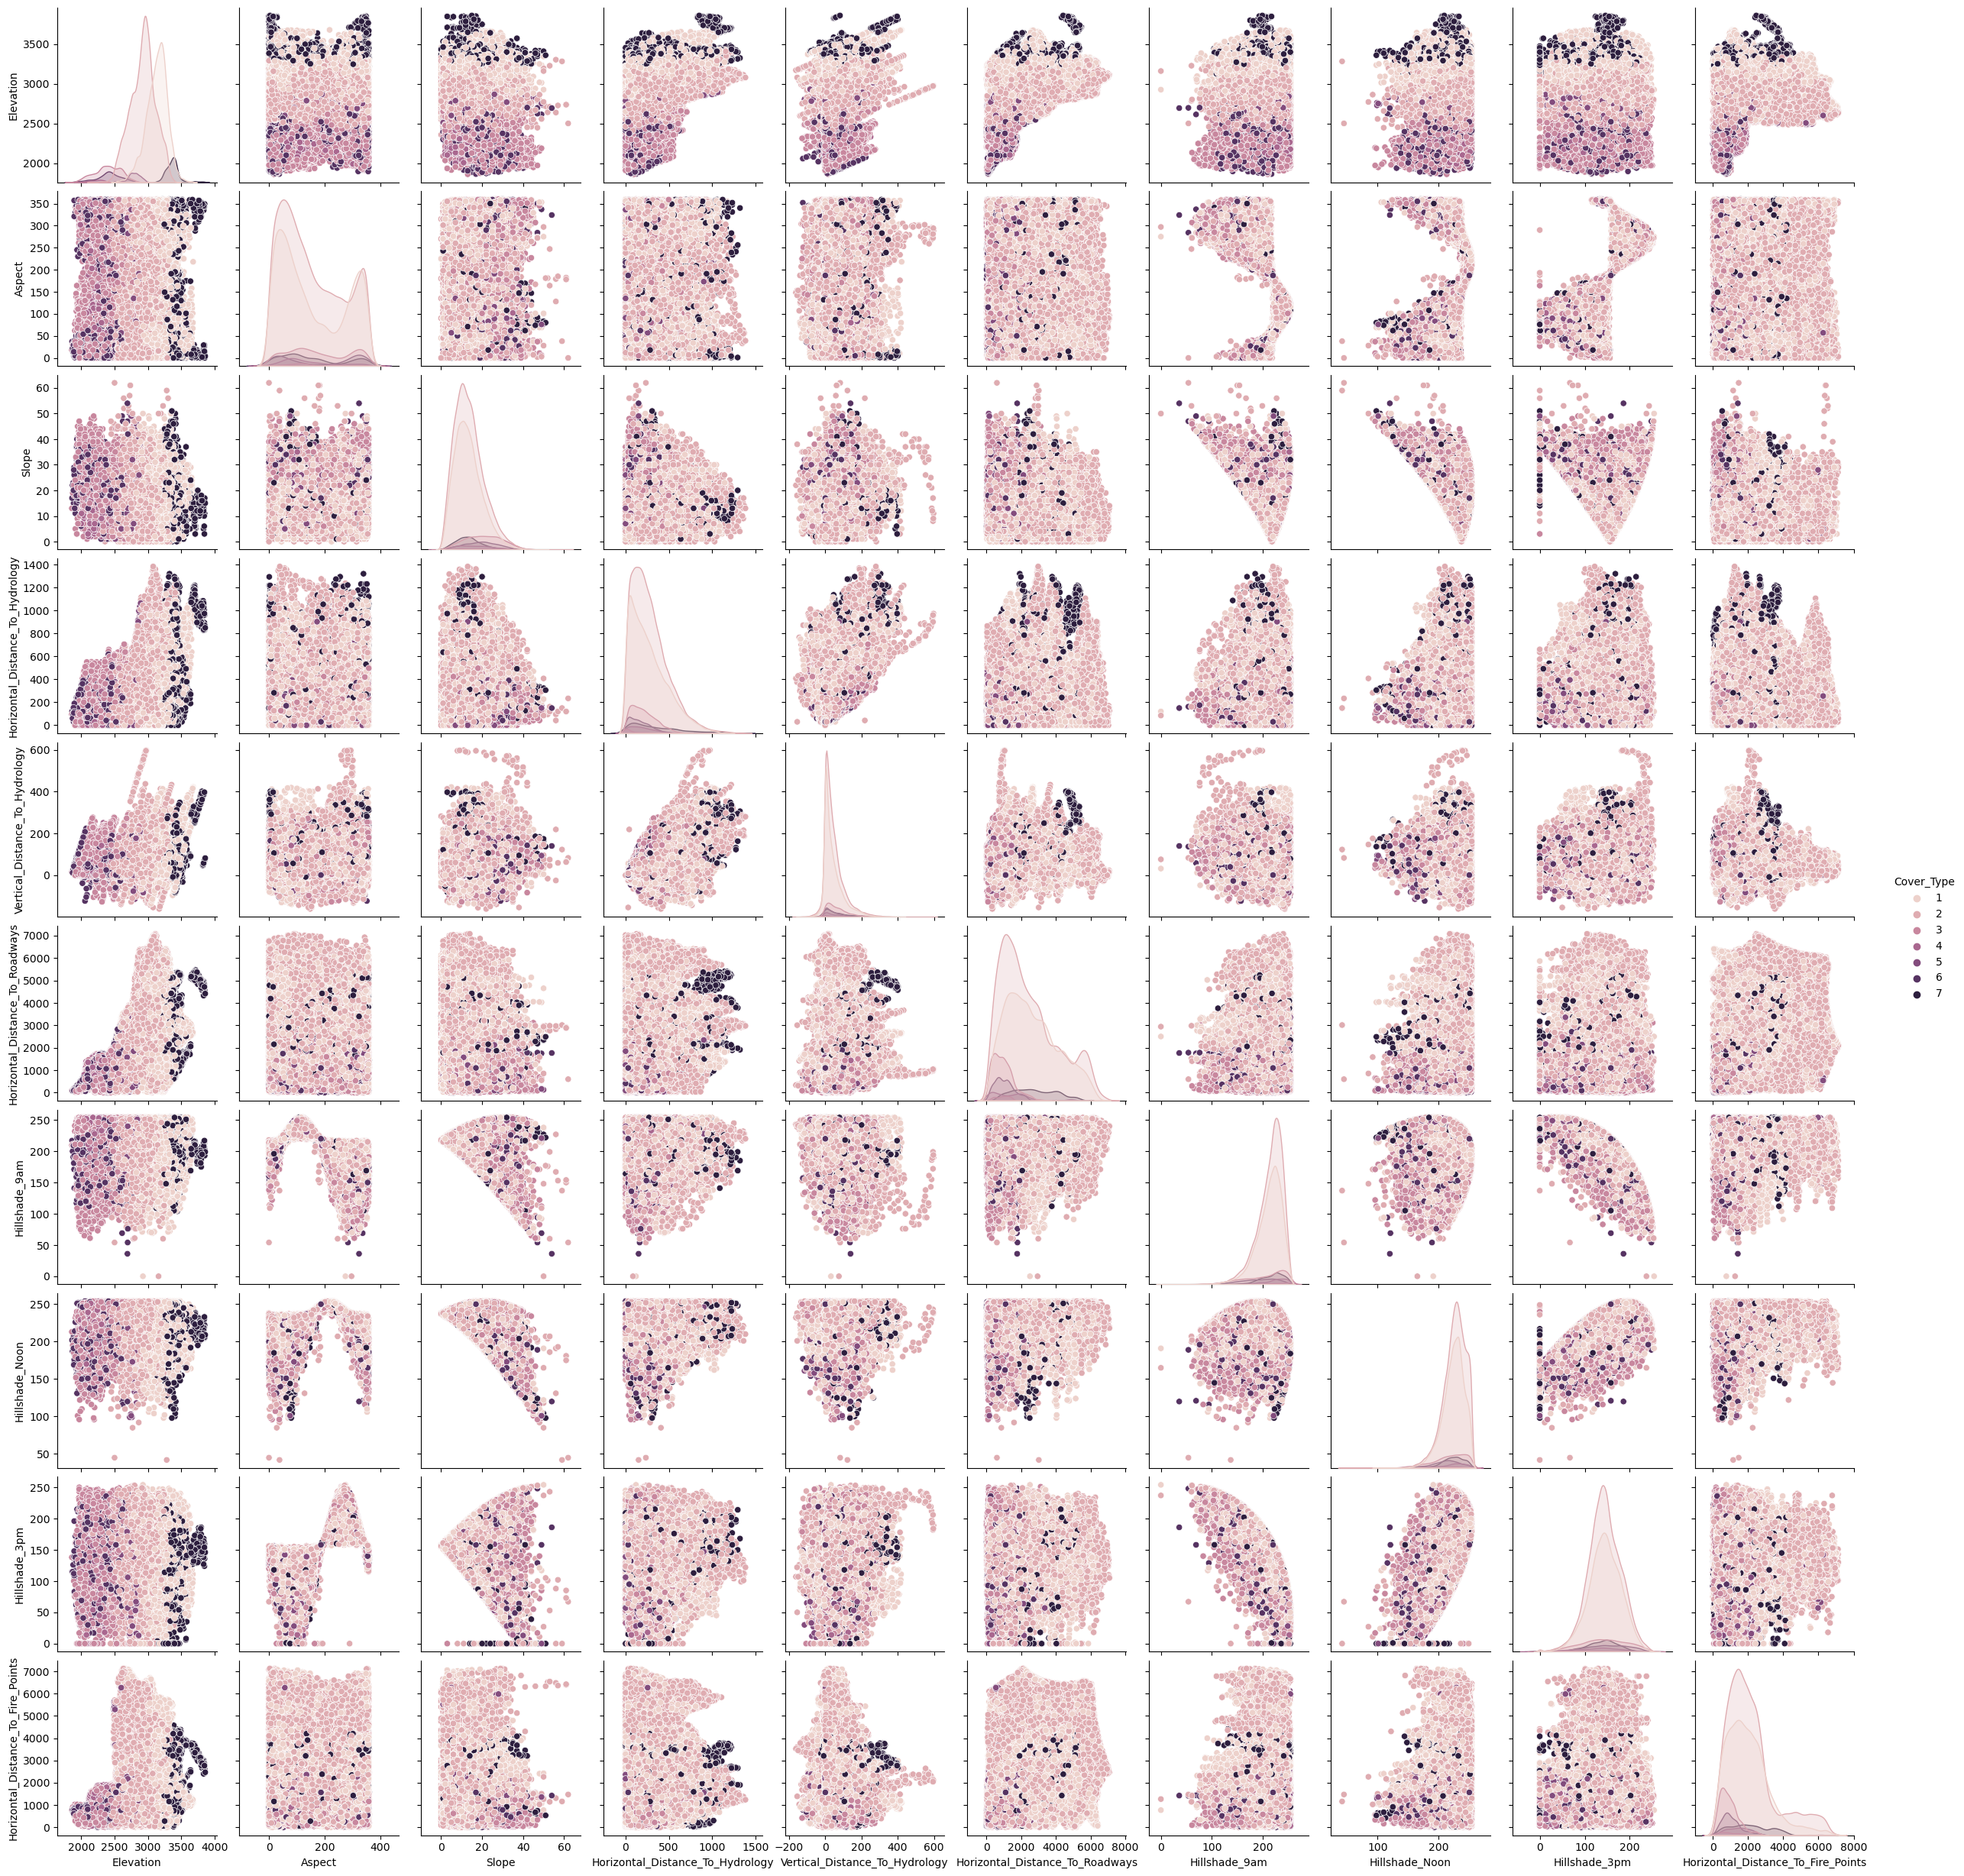

In [15]:
sns.pairplot(train_df.drop(columns=binary_columns), hue="Cover_Type")


Dans ce graphique `pairplot`, nous pouvons observer des relations non-linéaires entre certaines variables quantitatives.

- `Hillshade_3pm` et `Aspect` présentent une relation en forme de sigmoïde. Les points de données situés aux frontières du graphique appartiennent majoritairement à la classe `Cover_Type1`, tandis que la classe 3 occupe la majorité des points de données dans le graphique, suivie par la classe 6. Les points de données pour lesquels `Hillshade_3pm` est 0 appartiennent aux classes 1, 2, 3 ou 7, quel que soit la valeur de `Aspect`.

- Le graphique `Hillshade_9am` et `Aspect` montre également une relation en forme de sigmoïde, mais inversée sur l'axe des ordonnées. La classe 3 a ici le plus grand nombre d’observations, suivie par les classes 1 et 6.

- `Hillshade_Noon` et `Slope` forment une représentation en 'V' horizontal. Les faibles valeurs en degrés représentent les classes 4 et 6, tandis que les valeurs élevées représentent les classes 1, 2 et 7. On observe également une diminution des valeurs de `Hillshade_Noon` à mesure que la pente augmente, ce qui a du sens géographiquement.

- Les distances verticale et horizontale par rapport à l'`Hydrology` montrent un type de relation linéaire mais dispersée, sans ajustement précis à une ligne unique pour tous les points de données. Les classes 7 et 2 sont plus dispersées ici, tandis que les classes 3 et 6 sont densément regroupées dans la plage $0-800$ m pour la distance horizontale à l'`Hydrology`.

- Le graphique `Hillshade_9am` et `Hillshade_3pm` représente une relation en forme de portion de cercle, où la majorité des points de données dans la partie supérieure appartiennent à la classe 3, et les zones centrale et inférieure aux autres classes.

- `Hillshade_Noon` et `Hillshade_3pm` montrent une observation similaire à celle décrite précédemment, à la différence près que le graphique est inversé sur l'axe des ordonnées. On observe également des motifs similaires de points de données comme auparavant.

##### **Visualisation des spreads**

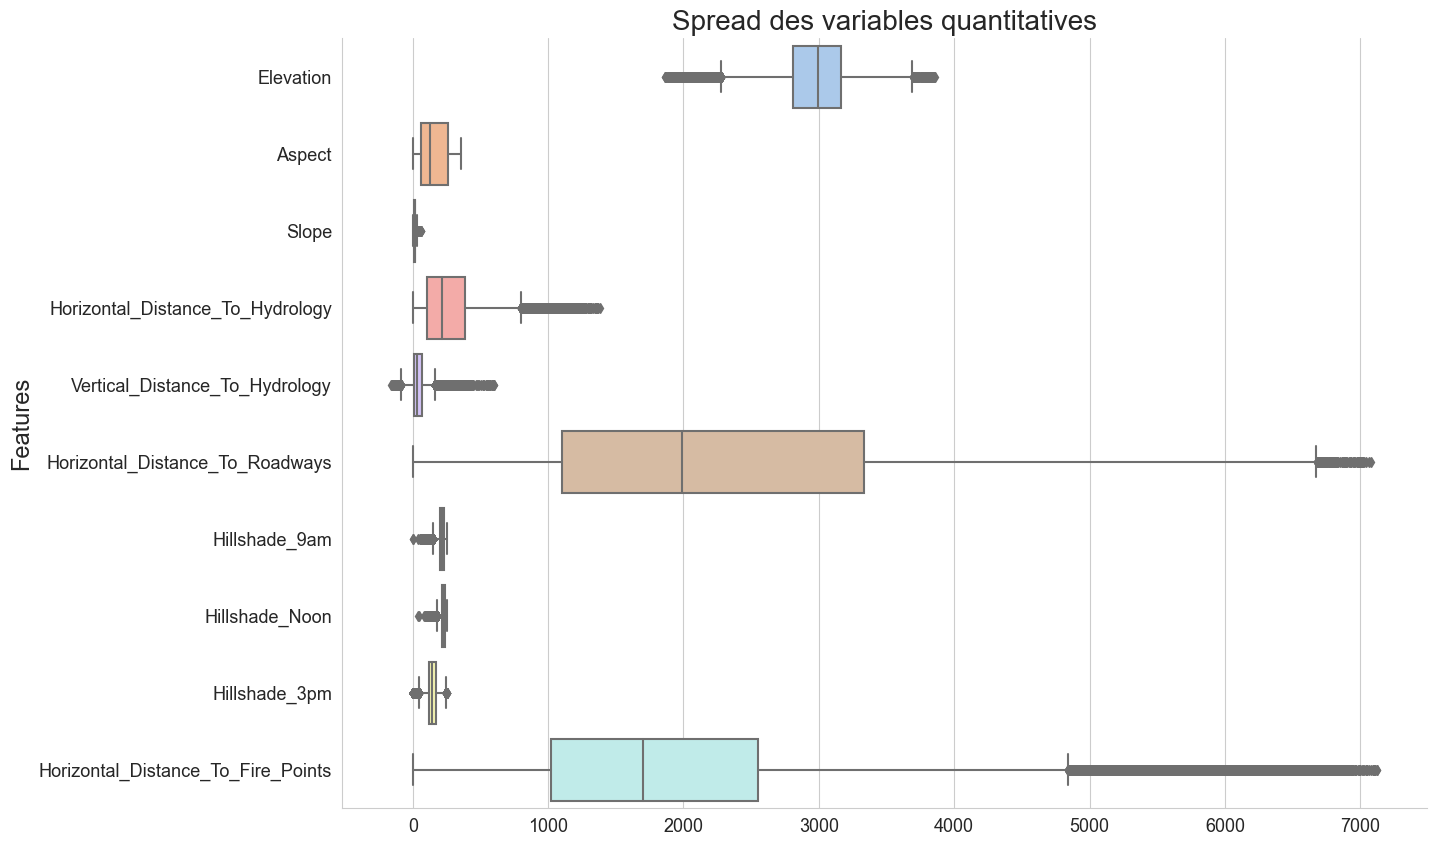

In [16]:
#####    1    ######
# Box plots
# Spread des variables quantitatives

sns.set_style("whitegrid")

plt.subplots(figsize=(14,10))

color = sns.color_palette('pastel')

# on affiche horizontalement pour une meilleure lisibilité
sns.boxplot(data = num_fea, orient='h', palette=color)

plt.title('Spread des variables quantitatives', size = 20)

plt.ylabel('Features', size = 17)

plt.xticks(size = 13)
plt.yticks(size = 13)

sns.despine()

plt.show()

- Comme évoqué précédemment, la variable `Slope` présente le box plot le plus comprimé. Elle est fortement concentrée, avec une plage très réduite par rapport à toutes les autres variables. Avoir une plage restreinte signifie que la moyenne et la médiane seront assez proches, comme nous l'avons vu précédemment dans le tableau, où la différence est d'environ 1. Toutefois, elle présente quelques outliers.

- `Aspect` est la seule variable qui ne présente aucun outlier, notamment dû au fait que la plage de valeur de cette variable est $[0,360]$. Étant donné que `Aspect` et `Slope` sont mesurés en degrés, `Aspect` couvre une plage beaucoup plus large que `Slope` en raison de sa valeur maximale plus faible. La première moitié des données, de min à la médiane, est plus concentrée que la seconde moitié, qui est plus dispersée.

- La variable `Hillshade` présente une distribution similaire à celle de `Slope`, avec de nombreux outliers et une plage plus réduite. Un graphique similaire est observé pour la variable `Vertical_Distance_To_Hydrology`, sauf que la valeur minimale est négative, comme nous l'avons vu dans le tableau.

- `Elevation` et `Horizontal_Distance_To_Hydrology` sont les seules variables qui n'ont pas de valeur minimale égale à 0. `Elevation`, quant à elle, est centrée, mais elle présente également de nombreux outliers.

- La variable `Horizontal_Distance_To_Roadways` est la plus dispersée de toutes, elle a l'écart-type le plus élevé, suivie de `Horizontal_Distance_To_Fire_Points`. Nous pouvons visualiser cette dispersion et voir laquelle est la plus grande. Il est probable que `Horizontal_Distance_To_Fire_Points` présente le plus grand nombre de valeurs aberrantes d'après ce graphique. Si nous comparons ces deux variables, la dernière moitié des données de `Horizontal_Distance_To_Roadways` est beaucoup plus dispersée et moins dense que celle de `Horizontal_Distance_To_Fire_Points`, ce qui explique son écart-type élevé.

##### **Visualisation des densités**

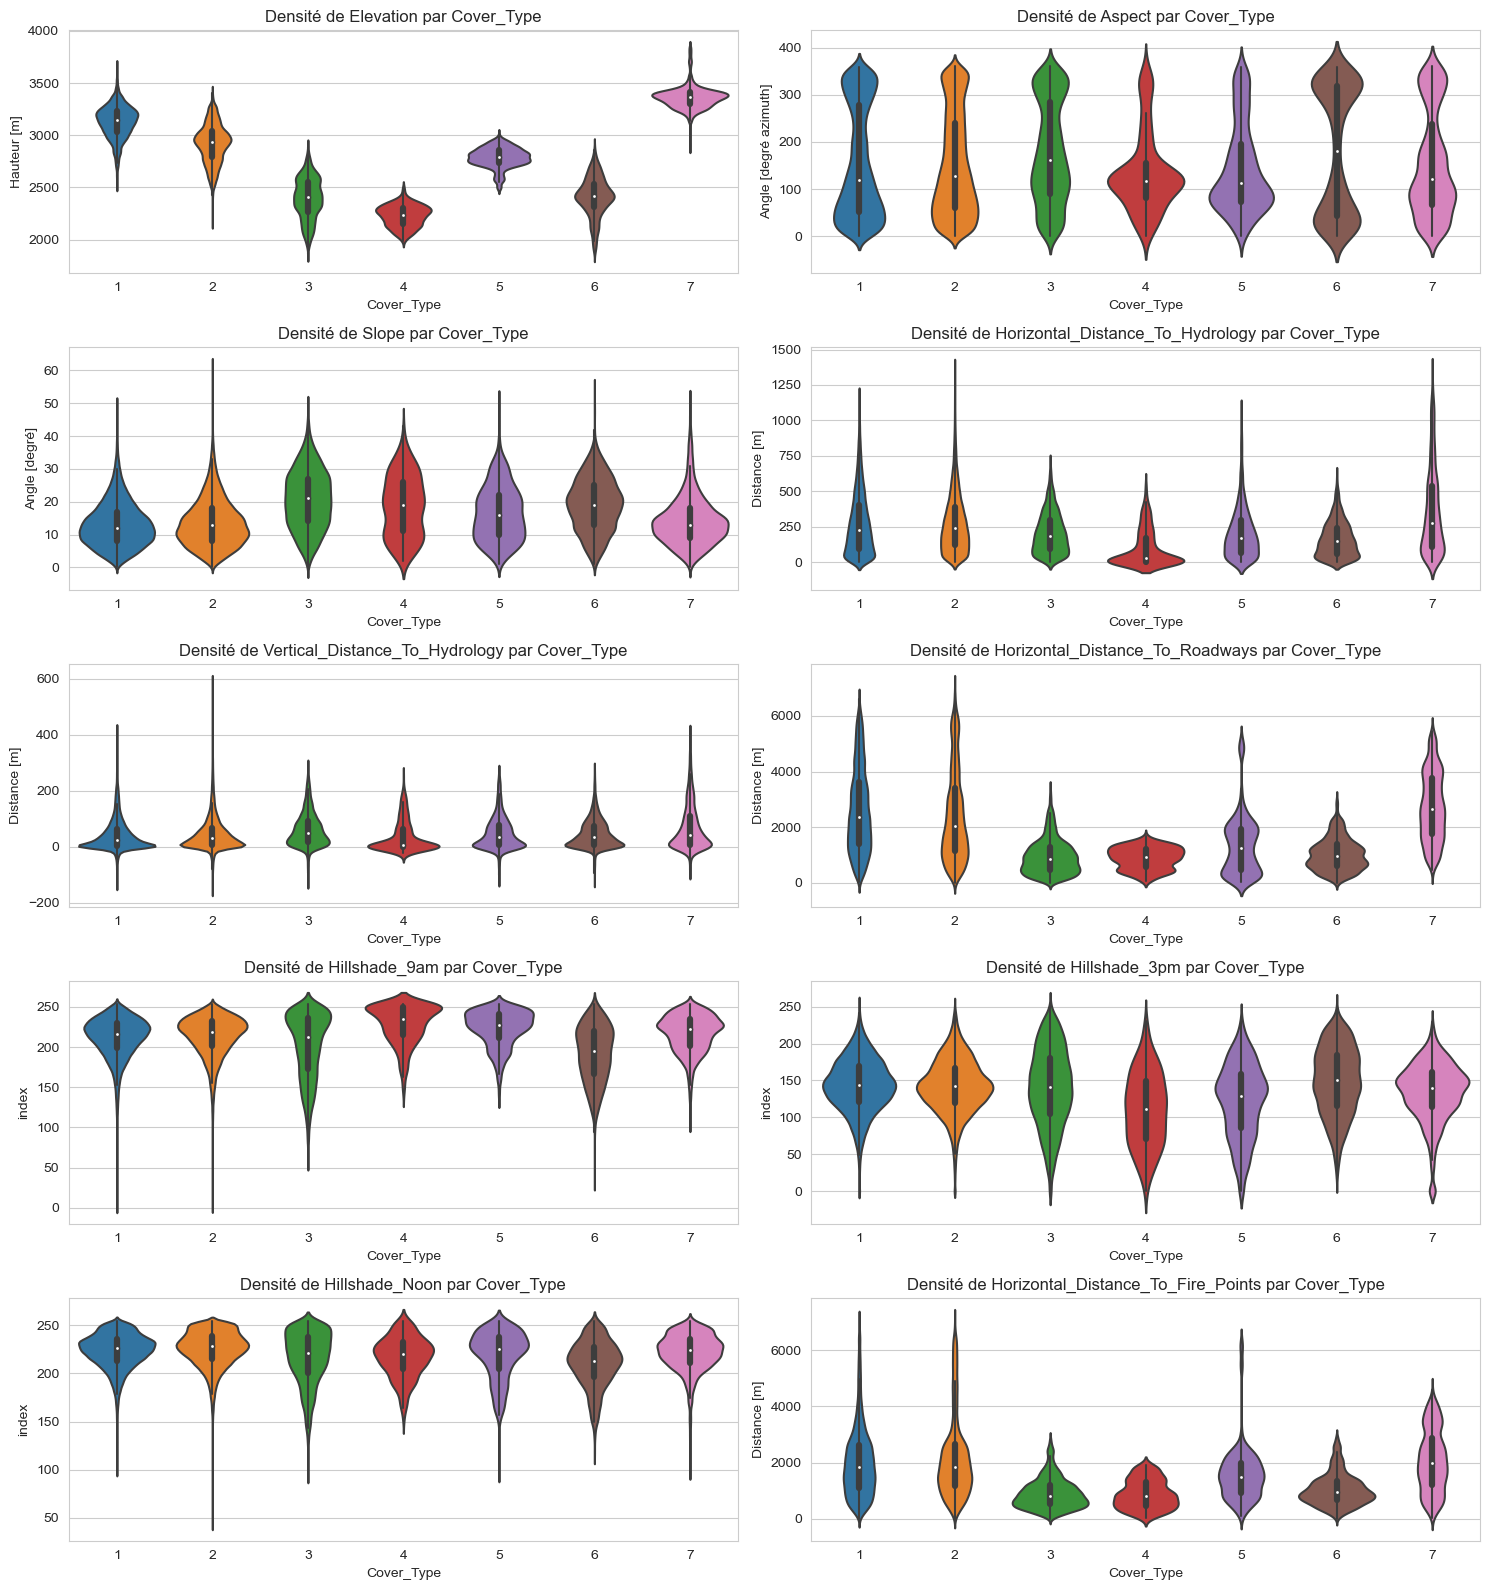

In [17]:
#####    2    ######
# densité des variables quantitatives par rapport à Cover_Type

fig, axs = plt.subplots(5, 2, figsize=(15, 16))

variables = [
    ('Elevation', 'Hauteur [m]'),
    ('Aspect', 'Angle [degré azimuth]'),
    ('Slope', 'Angle [degré]'),
    ('Horizontal_Distance_To_Hydrology', 'Distance [m]'),
    ('Vertical_Distance_To_Hydrology', 'Distance [m]'),
    ('Horizontal_Distance_To_Roadways', 'Distance [m]'),
    ('Hillshade_9am', 'index'),
    ('Hillshade_3pm', 'index'),
    ('Hillshade_Noon', 'index'),
    ('Horizontal_Distance_To_Fire_Points', 'Distance [m]')
]


# Subplot pour chaque variable de la liste ci-dessus
for i, (var, xlabel) in enumerate(variables):
    row, col = divmod(i, 2)  # Conversion de l'indice en position sur la grille

    # Tracer un diagramme en violon pour chaque Cover_Type
    sns.violinplot(
        data=train_df.drop(columns = binary_columns), 
        x='Cover_Type', 
        y=var, 
        ax=axs[row, col], 
        palette="tab10"
    )
    
    # Configuration des labels et titres
    axs[row, col].set_title(f'Densité de {var} par Cover_Type')
    axs[row, col].set_xlabel('Cover_Type')
    axs[row, col].set_ylabel(xlabel)

# Ajuster les espacements pour éviter les chevauchements
plt.tight_layout()
plt.show()


Dans le graphique ci-dessus, nous représentons des diagrammes en violon pour différentes variables quantitatives en fonction de la variable cible `Cover_Type`, ce qui permet de visualiser la distribution et la densité de chaque variable pour chaque classe.

`Elevation` : On observe des différences notables de densité pour `Elevation` entre les classes, avec des valeurs élevées pour les classes 5 et 7, et des valeurs plus basses pour la classe 1. Cela pourrait indiquer que l'altitude est une caractéristique importante pour distinguer certaines classes. En effet, nous pouvons observer que les supports des densités ne sont pas toutes confondues, ce qui permet de définir une première baseline basée sur cette variable `Elevation`.

`Aspect` : La variable `Aspect` montre des distributions similaires pour la plupart des classes, bien que la classe 3 ait une répartition légèrement plus étendue. L'ensemble des classes partage le même support et deux atome majoritaires se trouvent aux extrémités des distributions.

`Slope` : La pente semble montrer des variations modérées entre les classes, mais il y a un chevauchement important. Les classes 5 et 7, par exemple, montrent des distributions similaires, ce qui peut limiter l'influence de cette variable pour certaines classes.

`Horizontal_Distance_To_Hydrology` et `Vertical_Distance_To_Hydrology` : Les distances horizontale et verticale à l'hydrologie montrent des distributions variées. La classe 1, par exemple, semble se concentrer davantage autour de certaines valeurs spécifiques, ce qui pourrait indiquer que ces distances sont importantes pour identifier cette classe. La valeur la plus élevée de `Vertical_Distance_To_Hydrology` appartient à la classe `Cover_Type2`. De plus, `Vertical_Distance_To_Hydrology` présente la valeur minimale la plus faible parmi toutes les variables, qui appartient également à`Cover_Type2`. Ainsi, la classe 2 possède la plus grande étendue de données par rapport à toutes les autres classes.

`Horizontal_Distance_To_Roadways` : Cette variable montre une répartition intéressante, avec la classe 4 ayant une concentration plus élevée à des distances plus faibles. Cela pourrait être une variable importante pour distinguer certaines classes, notamment celles qui sont éloignées des routes.

`Hillshade_(9am, Noon, 3pm)` : Les indices de `Hillshade` montrent des densités relativement distinctes entre les classes. Ces variables semblent utiles pour distinguer des classes spécifiques, surtout à midi et à 9h du matin, où certaines classes comme 1 et 2 ont des répartitions particulières.

`Horizontal_Distance_To_Fire_Points` : Les distances horizontales aux points de feu montrent également des différences notables entre les classes, avec des concentrations de densité différentes. Cela pourrait être un bon indicateur pour séparer les classes, surtout pour les classes ayant des valeurs de distance nettement différentes.

En conclusion, des variables comme `Elevation`, `Horizontal_Distance_To_Hydrology`, `Horizontal_Distance_To_Roadways`, et `Horizontal_Distance_To_Fire_Points` semblent offrir de bonnes possibilités pour la classification, car elles montrent des différences marquées entre certaines classes.

##### **ACP**

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

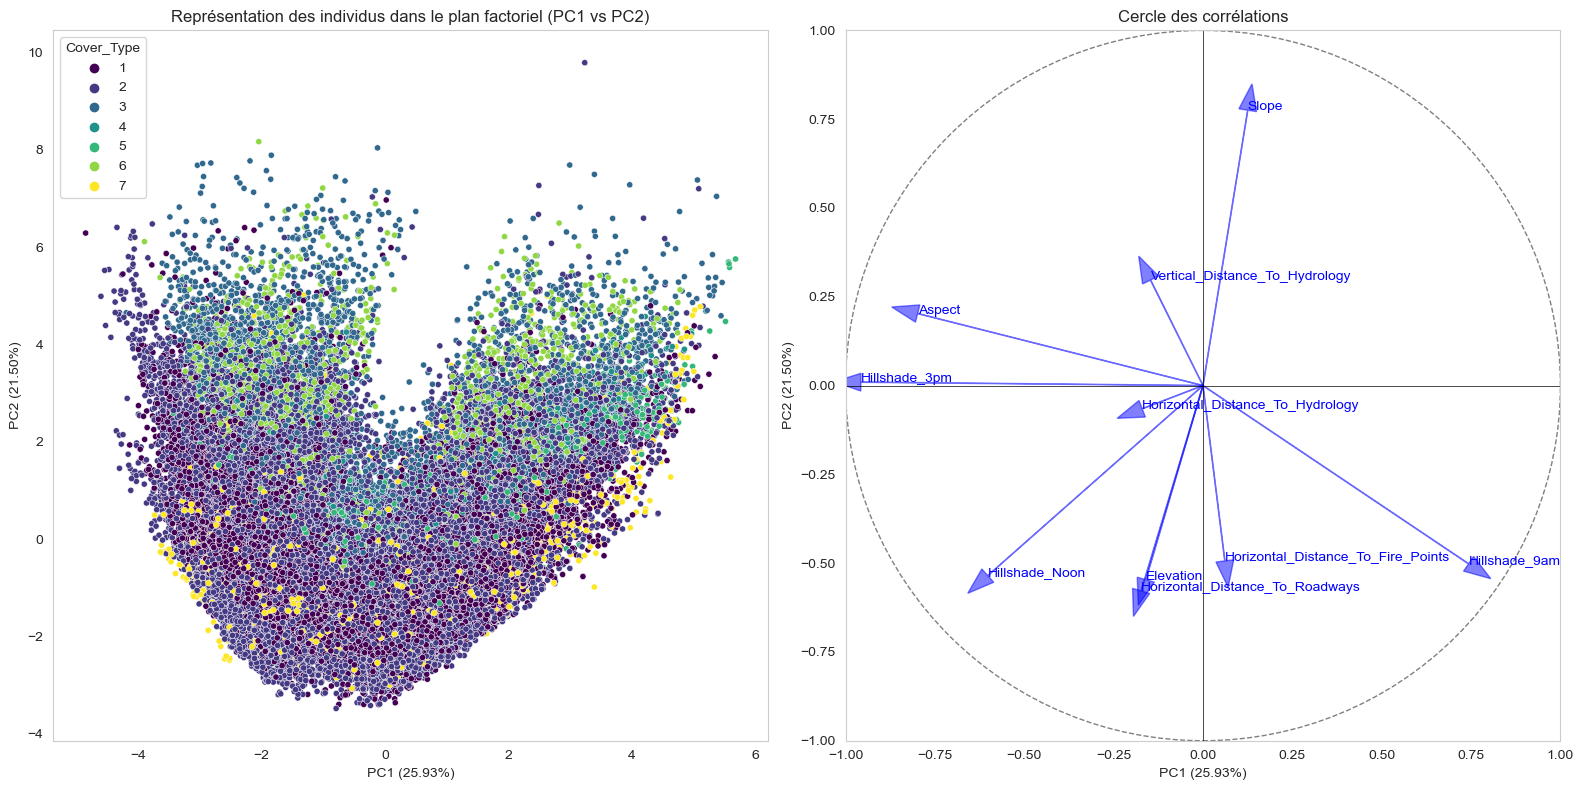

In [19]:
num_fea_standardized = StandardScaler().fit_transform(num_fea)

pca = PCA(n_components=2)  # On réduit à 2 dimensions pour la visualisation
principal_components = pca.fit_transform(num_fea_standardized)

# Convertir en DataFrame pour faciliter la manipulation
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca["Cover_Type"] = train_df["Cover_Type"]

# Calculer les composantes principales pour les variables (loadings) pour le cercle des corrélations
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Créer les subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ==========================
# Plan des individus
# ==========================
sns.scatterplot(x='PC1', y='PC2', hue='Cover_Type', data=df_pca, palette='viridis', s=20, ax=axes[0])
axes[0].set_title("Représentation des individus dans le plan factoriel (PC1 vs PC2)")
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
axes[0].grid()

# ==========================
# Cercle des corrélations (plan des variables)
# ==========================
for i, var in enumerate(num_fea.columns):
    axes[1].arrow(0, 0, loadings[i, 0], loadings[i, 1], color='b', alpha=0.5, head_width=0.05)
    axes[1].text(loadings[i, 0], loadings[i, 1], var, color='b')

# Ajouter le cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
axes[1].add_artist(circle)

# Configurer les limites de l'axe et le style pour le cercle des corrélations
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
axes[1].set_title("Cercle des corrélations")
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()


plt.tight_layout()
plt.show()

L'analyse du plan des individus montre une séparation des classes de `Cover_Type` sous la forme d'un "V", indiquant une structuration notable dans l'espace des deux premières composantes principales. Le bas du "V" est principalement occupé par les classes 1 et 2, tandis que le haut regroupe les classes 6, 5, 4 et 3, ce qui suggère une différenciation claire des classes selon certaines caractéristiques environnementales. La classe 7, quant à elle, apparaît dispersée autour du centre du "V", ce qui pourrait indiquer qu'elle est influencée de manière plus équilibrée par plusieurs variables, ou qu'elle représente une classe plus hétérogène.

D'après le plan des variables, les variables `Slope`, `Hillshade_3pm`, `Aspect`, `Hillshade_Noon` et `Hillshade_9am` contribuent fortement à la variabilité expliquée des composantes principales, soulignant leur importance dans la structuration du plan factoriel. Les flèches `Elevation` et `Horizontal_Distance_To_Roadways` indiquent une corrélation positive entre ces variables, tandis que celles de `Hillshade_9am` et `Aspect` indiquent une corrélation négative. En ce qui concerne les axes principaux, `Aspect` et `Hillshade_3pm` sont alignées avec l'axe 1, indiquant qu'elles influencent fortement cette composante, tandis que `Slope` et `Horizontal_Distance_To_Fire_Points` ont une plus grande influence sur l'axe 2, suggérant que l'axe 2 capture la variabilité liée à l'élévation et à la distance aux feux de forêt, tandis que l'axe 1 est davantage influencé par l'orientation et l'ensoleillement.

##### **Matrice des coorélations**

Étant donné que nous analysons dans cette partie des variables quantitatives, nous pouvons étudier leurs corrélations afin de mieux comprendre les relations entre les différentes variables et leur influence potentielle sur la classe cible `Cover_Type`.

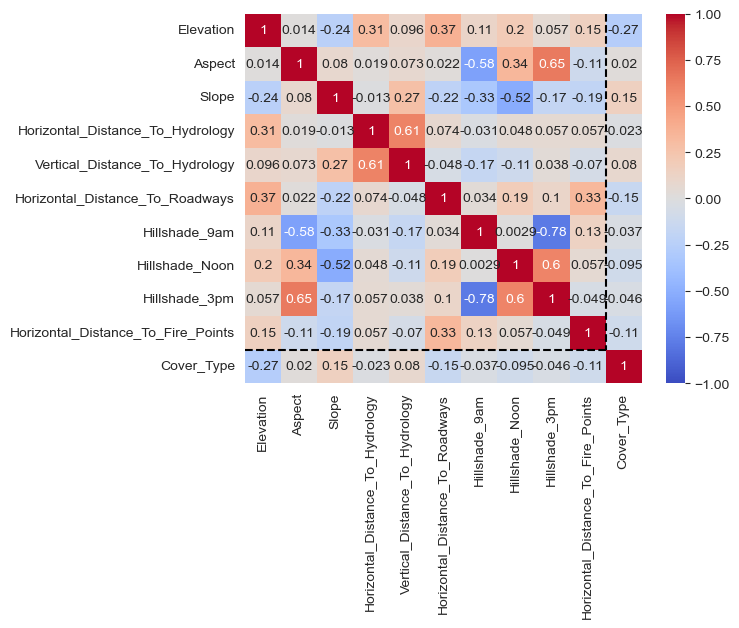

In [20]:

fig, ax = plt.subplots(1, 1)
sns.heatmap(train_df.drop(columns=binary_columns).corr(), annot=True, vmin = -1, vmax = 1 , cmap='coolwarm', ax=ax)
nvarexp = train_df.drop(columns=binary_columns).shape[1] - 1
ax.plot([0, nvarexp], [nvarexp, nvarexp], linestyle='--', color='black')
ax.plot([nvarexp, nvarexp], [0, nvarexp], linestyle='--', color='black')

plt.show()

La matrice des corrélations de Pearson ci-dessus nous montre les corrélations linéaires entre les différentes variables quantitatives. Nous pouvons observer que la variable objectif `Cover_Type` a sa plus grande corrélation négative, à $-0,27$, avec `Elevation` et positive, à $0,15$ avec `Slope`. De plus, nous pouvons considérer que les variables ayant la plus grande corrélation linéaire avec `Cover_Type` sont `Elevation`, `Slope`, `Horizontal_Distance_To_Roadways` et `Horizontal_Distance_To_Fire_Points` (les autres variables ont une corrélation de magnitude $10^{-3}$).

Nous pouvons aussi observer des corrélations élevées entre les variables quantitatives :

- La variable `Hillshade_3pm` a de nombreuses corrélations supérieures (en valeur absolue) à $0,5$, notamment à $-0,78$ avec `Hillshade_9am` et $0,6$ avec `Hillshade_Noon`. Les variables `Hillshade` sont donc fortement corrélées entre elles. Elles sont aussi corrélées avec `Aspect` et `Slope`.

- Les variables de distance à l'`Hydrology` sont aussi corrélées entre elles à hauteur de $0,61$, montrant une corrélation linéaire entre ces variables.

Nous avons donc 6 paires de variables corrélées (linéairement) entre elles, tandis que des valeurs moins corrélées indiquent que les caractéristiques contiennent des informations différentes et précieuses pour nous et pour le modèle, et sont donc des caractéristiques importantes pour les prédictions.

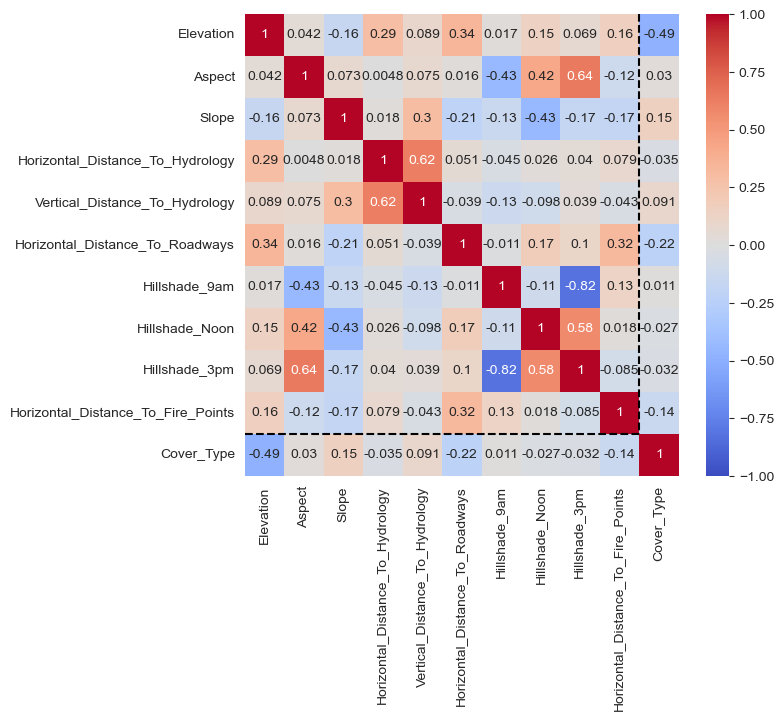

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (7,6) )
sns.heatmap(train_df.drop(columns=binary_columns).corr(method="spearman"), annot=True, vmin = -1, vmax = 1 , cmap='coolwarm', ax=ax)
nvarexp = train_df.drop(columns=binary_columns).shape[1] - 1
ax.plot([0, nvarexp], [nvarexp, nvarexp], linestyle='--', color='black')
ax.plot([nvarexp, nvarexp], [0, nvarexp], linestyle='--', color='black')

plt.show()

La matrice des corrélations de Sperman est utilisée pour mesurer la relation monotone entre deux variables et ainsi détecter les non linéarités entre elles.

- La classe `Cover_Type` admet une corrélation élevée avec la variable `Elevation` tandis que la corrélation avec `Horizontal_Distance_To_Roadways` n'a pas changé.

- Les variables `Aspect` et `Hillshade_3pm` admettent aussi une corrélation non linéaire élevée. 

- Nous observons aussi des corrélations élevés pour les variables `Hillshade`.

#### **Visualisation des variables catégorielles**

Nous allons à présent étudier les 4 classes de variables catégorielle : `Wilderness_Area`, `Soil_Type`, `Climatic_Zone` et `Geologic_Zone`. 

##### **Densités**

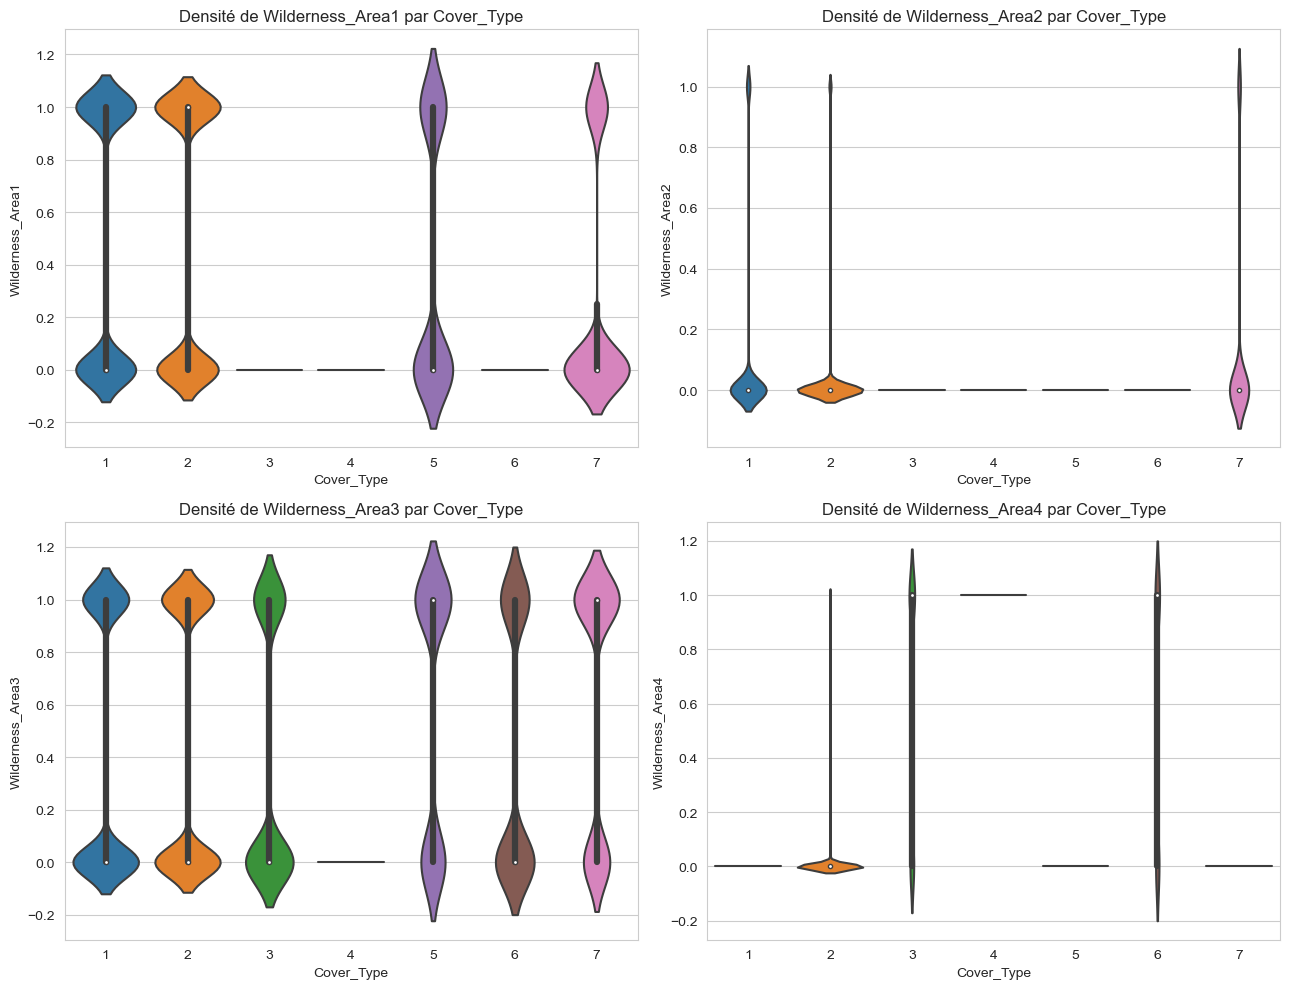

In [22]:
# Visualisation des densités de Wilderness_Area

Wilderness_Area = [f"Wilderness_Area{i}" for i in range(1,5)]

ig, axs = plt.subplots(2,2, figsize=(13,10))

# Subplot pour chaque variable catégorielle
for i, var in enumerate(Wilderness_Area):
    row, col = divmod(i, 2)
    
    # Tracer le diagramme en violon pour chaque Cover_Type
    sns.violinplot(
        data=train_df[Wilderness_Area + ["Cover_Type"]], 
        x='Cover_Type', 
        y=var, 
        ax=axs[row, col],
        palette="tab10"
    )
    
    # Configuration des labels et titres
    axs[row, col].set_title(f'Densité de {var} par Cover_Type')
    axs[row, col].set_xlabel('Cover_Type')
    axs[row, col].set_ylabel(var)

# Ajuster les espacements pour éviter les chevauchements
plt.tight_layout()
plt.show()

La raison pour laquelle ces graphiques apparaissent très différents de ceux d'avant est que ces caractéristiques prennent des valeurs comprises entre 0 et 1.

- `Wilderness_Area1` appartient aux classes 1, 2, 5 et 7, tandis que `Wilderness_Area3` est présente dans toutes les classes, sauf la 4.

- `Wilderness_Area2` et `4` contiennent moins d’observations ; leur densité est moins marquée sur la valeur 1 pour toutes les classes par rapport aux deux autres `Wilderness_Area1` et `3`.

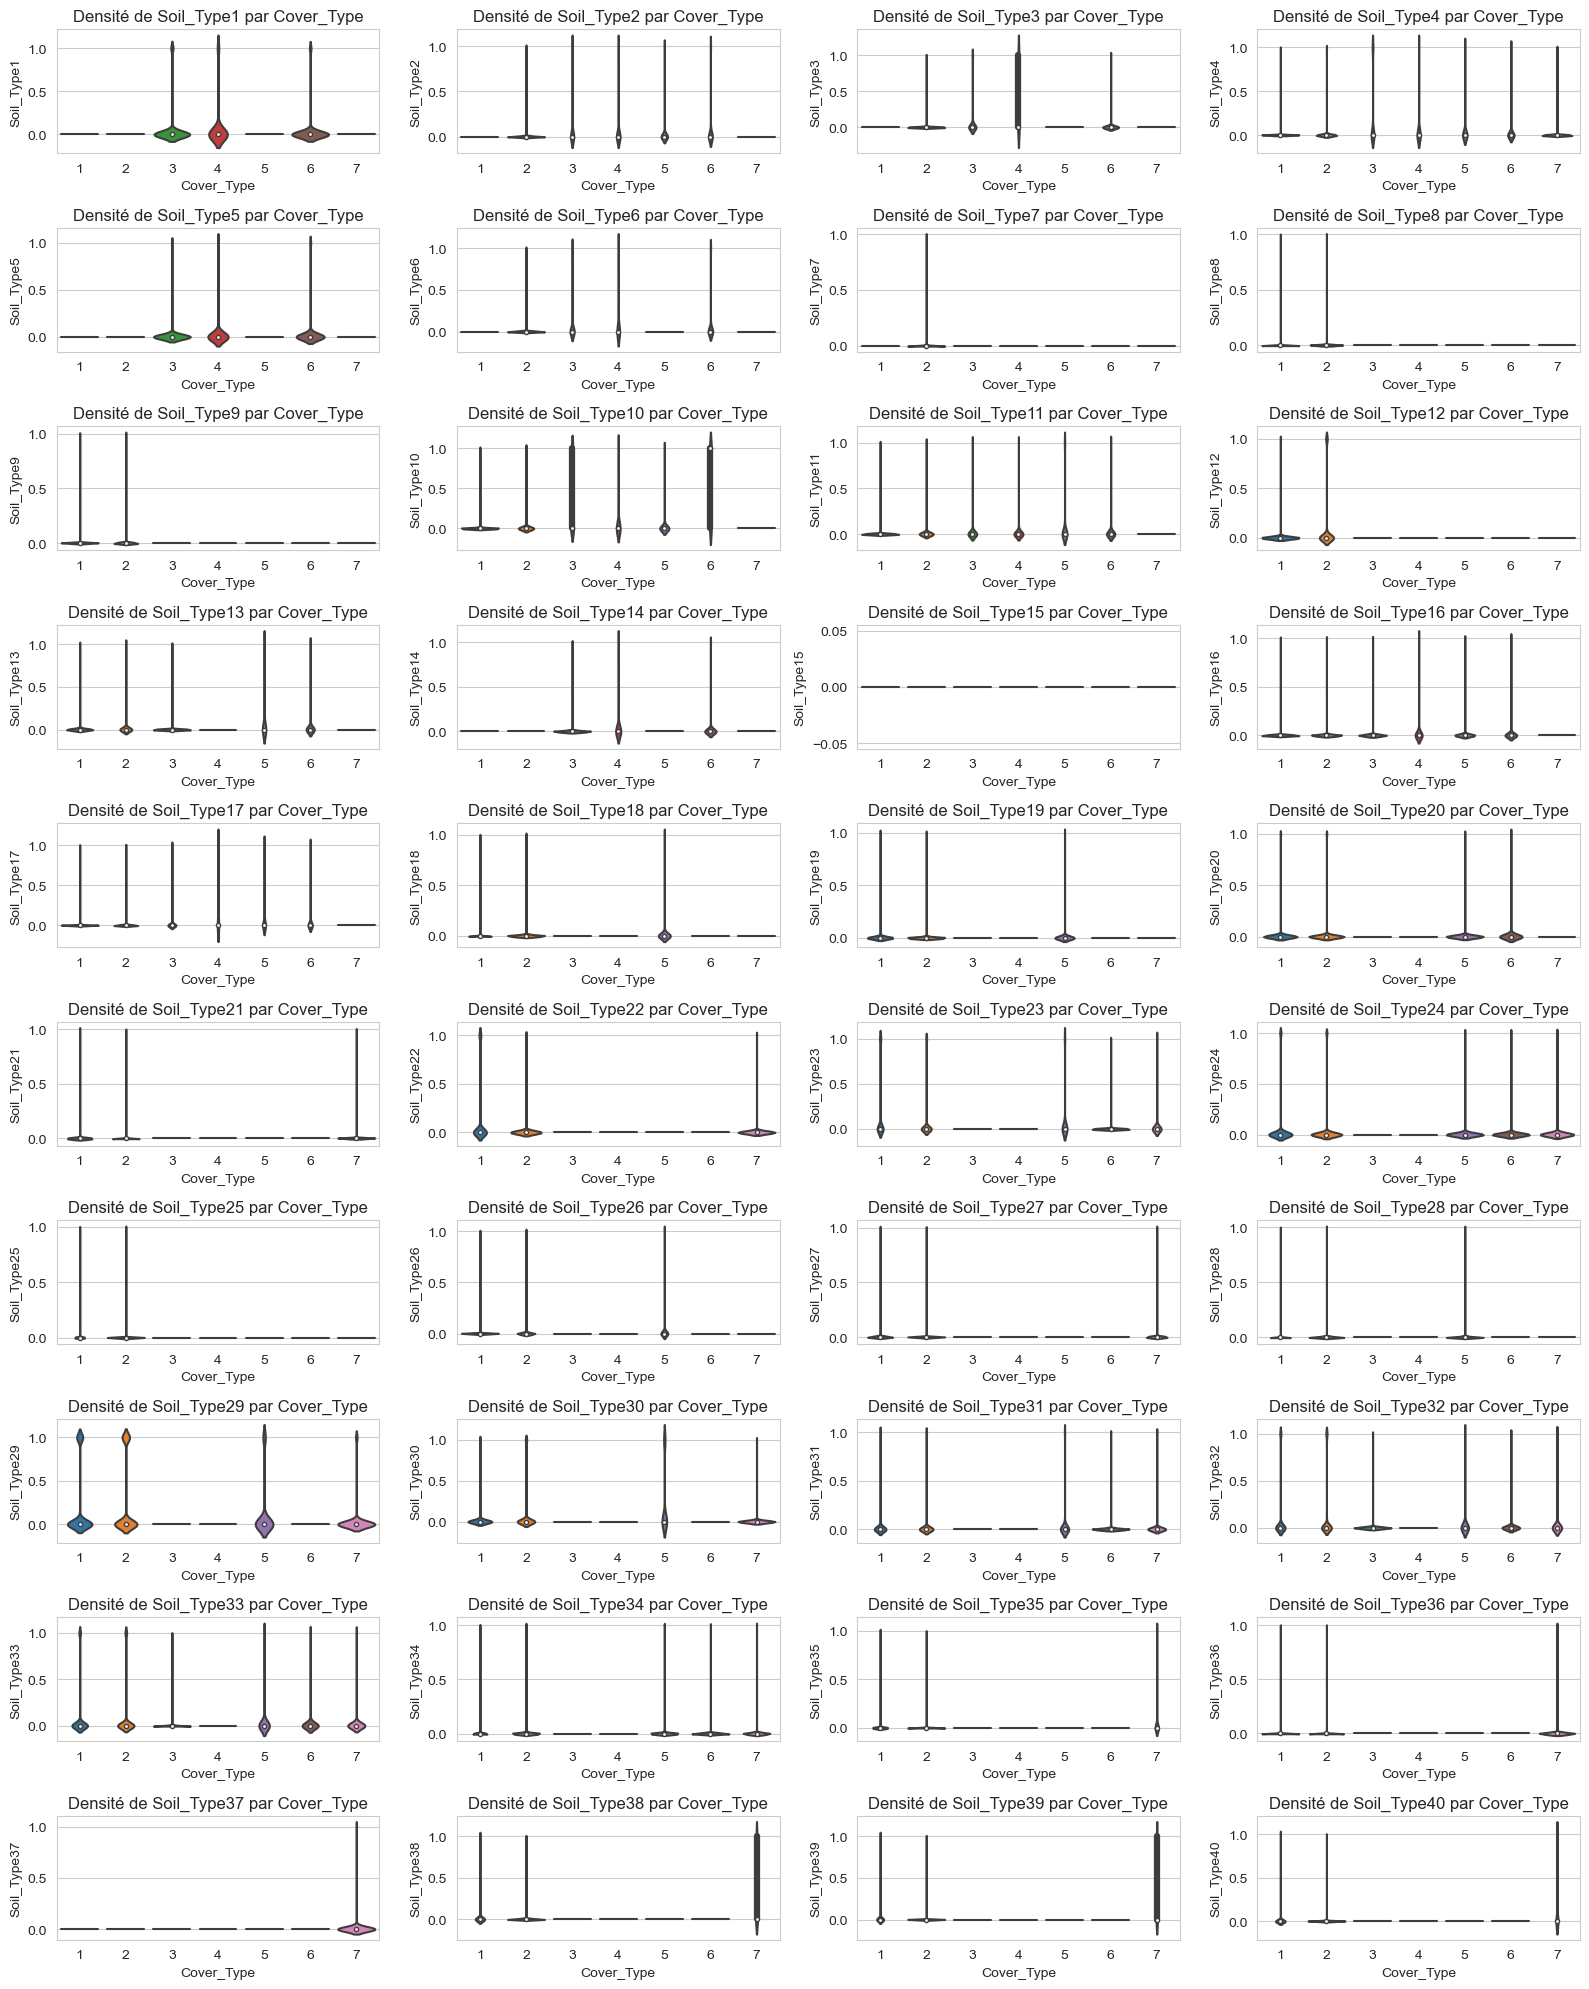

In [23]:
# Visualisation des densités de Soil_Type

ig, axs = plt.subplots(10,4, figsize=(16,20))

# Subplot pour chaque variable catégorielle
for i, var in enumerate(soil_type):
    row, col = divmod(i, 4)
    
    # Tracer le diagramme en violon pour chaque Cover_Type
    sns.violinplot(
        data=train_df[soil_type + ["Cover_Type"]], 
        x='Cover_Type', 
        y=var, 
        ax=axs[row, col],
        palette="tab10"
    )
    
    # Configuration des labels et titres
    axs[row, col].set_title(f'Densité de {var} par Cover_Type')
    axs[row, col].set_xlabel('Cover_Type')
    axs[row, col].set_ylabel(var)

# Ajuster les espacements pour éviter les chevauchements
plt.tight_layout()
plt.show()

- `Soil_Type4` est le seul type de sol présent dans toutes les classes.

- Les `Soil_Type` `7`, `15` et `37` appartiennent respectivement aux classes `Cover_Type` `2`, `6` et `7`. Ils présentent également le plus petit nombre d'observations parmi tous les `Soil_Type`. La présence des `Soil_Type` `7`, `15` et `37` indique très probablement une appartenance aux classes `Cover_Type` `2`, `6` et `7` respectivement. Bien qu'ils aient peu d'observations, nous pensons que ces `Soil_Type` constituent une caractéristique importante car ils fournissent des informations précieuses. Cela dit, il est possible que d'autres caractéristiques apportent également des informations significatives pour ces classes. C’est un point que l’on pourrait débattre, mais seuls les modèles peuvent réellement nous dire quelles caractéristiques influencent le plus les prédictions.

- `Cover_Type4` semble moins présent dans toutes les `Soil_Type`, y compris pour les `Soil_Type` avec peu d'observations.

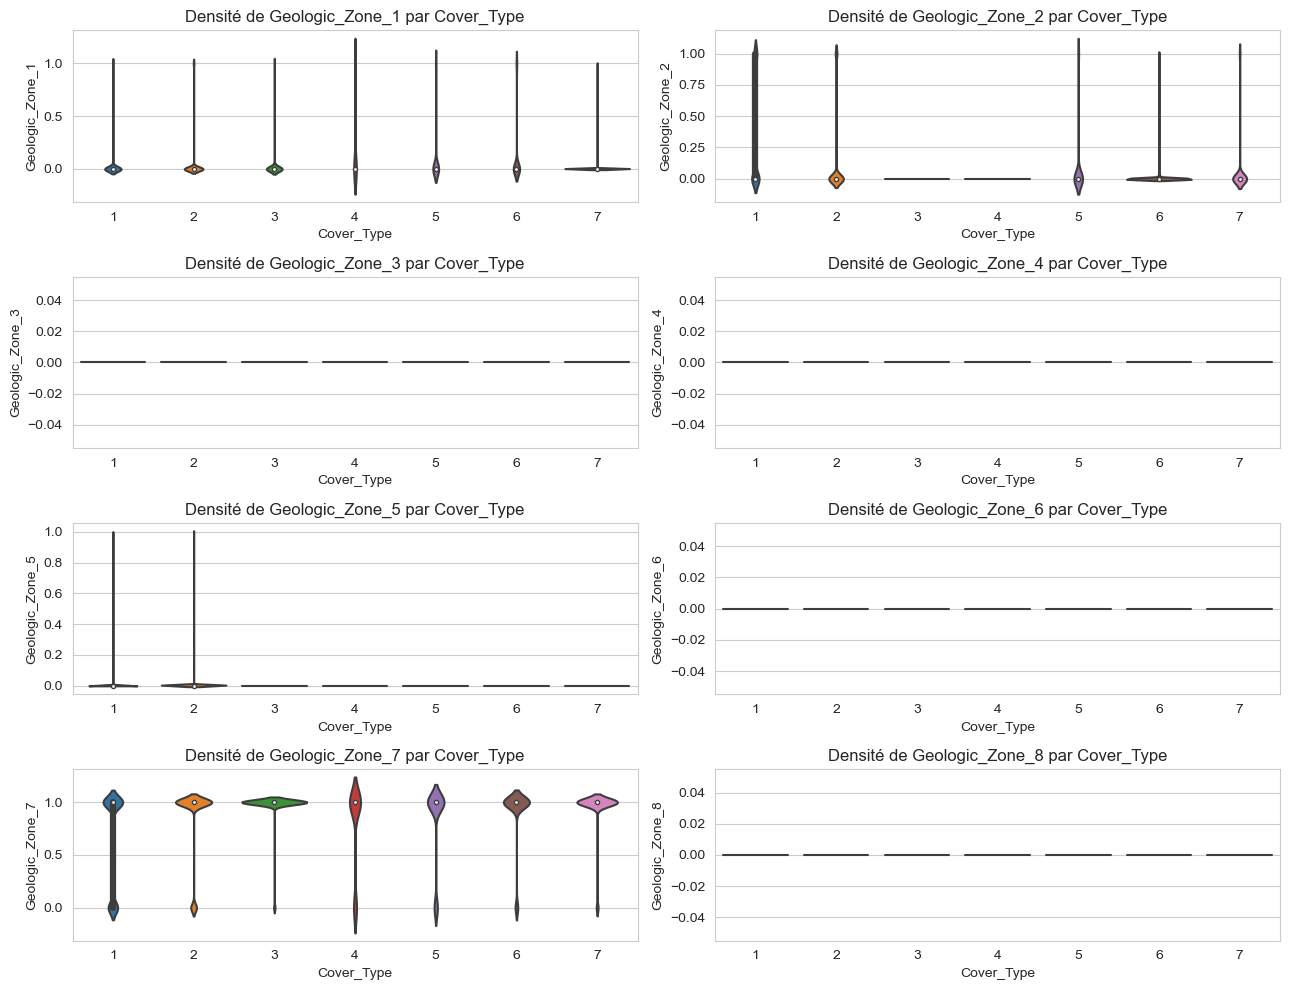

In [24]:
# Visualisation des densités de Geologic_Zone

Geologic_Zone = [f"Geologic_Zone_{i}" for i in range(1,9)]

ig, axs = plt.subplots(4,2, figsize=(13,10))

# Subplot pour chaque variable catégorielle
for i, var in enumerate(Geologic_Zone):
    row, col = divmod(i, 2)
    
    # Tracer le diagramme en violon pour chaque Cover_Type
    sns.violinplot(
        data=train_df[Geologic_Zone + ["Cover_Type"]], 
        x='Cover_Type', 
        y=var, 
        ax=axs[row, col],
        palette="tab10"
    )
    
    # Configuration des labels et titres
    axs[row, col].set_title(f'Densité de {var} par Cover_Type')
    axs[row, col].set_xlabel('Cover_Type')
    axs[row, col].set_ylabel(var)

# Ajuster les espacements pour éviter les chevauchements
plt.tight_layout()
plt.show()

- Les `Geologic_Zone` `3`, `4`, `6` et `8` sont toutes fixées à 0. En effet, nous n'avons pas d'observations de ces zones dans nos données.

- La `Geologic_Zone_7` est la zone la plus représentée dans nos données, comme peut le montrer les fortes densités en 1.

- Les `Geologic_Zone_5` et `2` sont quant à elles exprimées dans respectivement 2 et 5 classes.

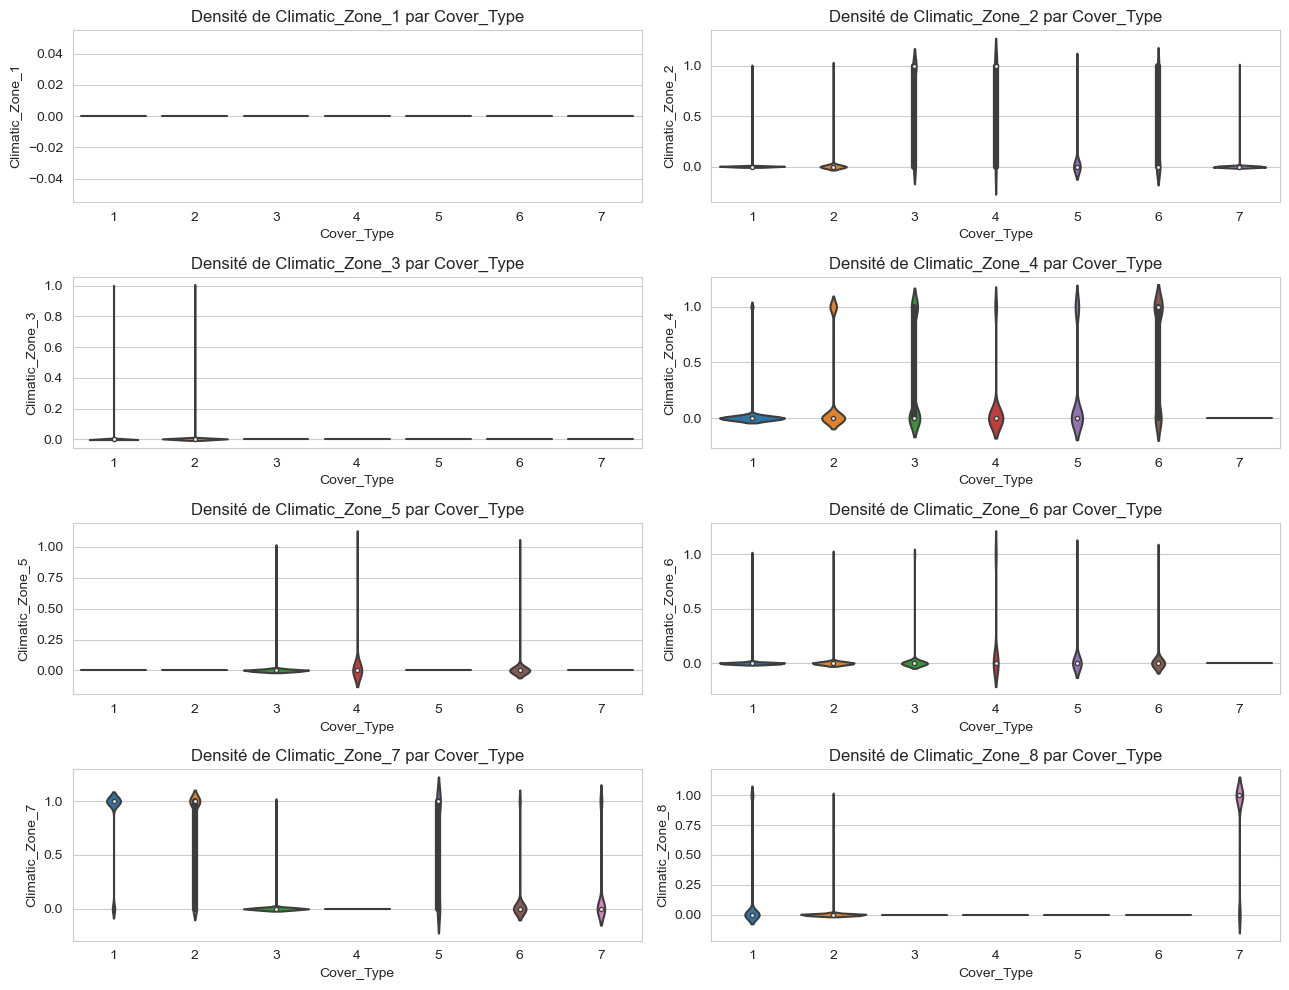

In [25]:
# Visualisation des densités de Geologic_Zone

Climatic_Zone = [f"Climatic_Zone_{i}" for i in range(1,9)]

ig, axs = plt.subplots(4,2, figsize=(13,10))

# Subplot pour chaque variable catégorielle
for i, var in enumerate(Climatic_Zone):
    row, col = divmod(i, 2)
    
    # Tracer le diagramme en violon pour chaque Cover_Type
    sns.violinplot(
        data=train_df[Climatic_Zone + ["Cover_Type"]], 
        x='Cover_Type', 
        y=var, 
        ax=axs[row, col],
        palette="tab10"
    )
    
    # Configuration des labels et titres
    axs[row, col].set_title(f'Densité de {var} par Cover_Type')
    axs[row, col].set_xlabel('Cover_Type')
    axs[row, col].set_ylabel(var)

# Ajuster les espacements pour éviter les chevauchements
plt.tight_layout()
plt.show()

Contrairement à `Geologic_Zone`, les `Climatic_Zone` sont bien plus représentées dans les différentes classes.

- Les variables `Climatic_Zone_8`, `5` et `3` admettent des densités pour 3 classes de `Cover_Type` permettant ainsi une distinction de ces classes.

- Les variables discriminantes semblent donc être les `Climatic_Zone` `8`, `5` et `3`, tandis que les autres montrent des densités similaires pour toutes les classes.

## Enregistrement des nouvelles données

In [26]:
train_df.to_csv(_REP_PATH_+'/data/train_nettoye.csv') 
test_df.to_csv(_REP_PATH_+'/data/test_nettoye.csv') 